# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [175]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
%autocall 1
%load_ext autoreload
%autoreload 2

In [215]:
import shutil
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

In [162]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=8
npartitions=os.cpu_count()-1
assert npartitions>0

# define module

In [376]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    Example Usage:
dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
    """
    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    # #DONE: compute spiral tip locations and verify that they look reasonable
    #compute flow map
    zero_txt=np.zeros_like(txt)
    dtxt_dt=zero_txt#.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)

    #compress data to be plotted
    # dimg_dt=dtxt_dt[...,0]
    # img=txt[...,0]
    dimg_dt=dtxt_dt[...,0].astype(np.float32) #looks the same as float64
    img=txt[...,0].astype(np.float32)
    # dVdt=dtxt_dt[...,0].astype(np.float16) #this bugs up the streamplots
    # img=txt[...,0].astype(np.float16)
    return dict_out,img,dimg_dt

In [378]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
    #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
    #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

    #compute the streamplot
    X_=np.arange(width)
    Y_=np.arange(height)
    #X,Y = np.meshgrid(X_, Y_)
    #compute vector field
    ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
    vx=-ddVdtdx #looks good
    vy=-ddVdtdy
    # vx=ddVdtdx #looks meh
    # vy=ddVdtdy
    strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                         density=0.5)#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        start_points = list(zip(x_values,y_values))
        strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    label=r"$-\nabla \partial_tV$"#+'\n'
    ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

In [286]:
1

1

# test my gpu accelerated one_step method for the Fenton-Karma model

200000 time steps took 14355 ms.


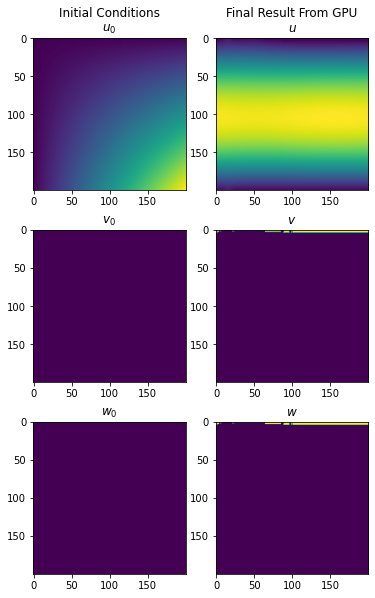

In [31]:
# from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
# drv.init()

#define how resources are used
width  = 200
height = 200
block_size_x=10
block_size_y=10
threads = (block_size_x,block_size_y,1)
grid = (int(width/block_size_x, int(height/block_size_y), 1)
block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

#set spatial discretization
DX=0.025 #cm
# DY=0.025
DT=0.025 #ms

#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#load parameters for parameter set 8 for the Fenton-Karma Model
kwargs = read_parameters_from_json('lib/model/param_set_8.json')
kwargs['width']=width
kwargs['height']=height
kwargs['DX']=DX
# kwargs['DT']=DT
# kwargs['DY']=DY

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

In [12]:
print_dict(kwargs)

diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04
width=200
height=200
DX=0.025


## print the kernel_string for the one_step method for the Fenton-Karma model

In [362]:
print(kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# dev

In [382]:
from lib.viewer.viewer_cluster import *

In [ ]:
# load an initial conditions and integrate forward 100ms
printing=False
tf=100.
iterations = int(np.around(tf/DT))
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-in/'
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'

ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
"ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)
    # plt.imshow(txt[...,0],cmap='gray')
    # plt.axis('off')
    # plt.show()

    t=0

    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={iterations})...")

    #define the initial conditions
    u_initial=txt[...,0].copy()
    v_initial=txt[...,1].copy()
    w_initial=txt[...,2].copy()

    #don't allocate memory many times for the same task!
    #allocate GPU memory for voltage scalar field
    u_old = drv.mem_alloc(u_initial.nbytes)
    u_new = drv.mem_alloc(u_initial.nbytes)
    #allocate GPU memory for v and w auxiliary fields
    v_old = drv.mem_alloc(v_initial.nbytes)
    v_new = drv.mem_alloc(v_initial.nbytes)
    w_old = drv.mem_alloc(w_initial.nbytes)
    w_new = drv.mem_alloc(w_initial.nbytes)

    # explicit time integration up to 5 seconds in steps of size 0.025 ms
    kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

    #setup thread block dimensions and compile the kernel
    mod = SourceModule(block_size_string+kernel_string)
    time_step_kernel = mod.get_function("time_step_kernel")

    # #create events for measuring performance
    # start_timer = drv.Event()
    # end_timer = drv.Event()

    #move the data to the GPU
    drv.memcpy_htod(u_old, u_initial)
    drv.memcpy_htod(u_new, u_initial)
    drv.memcpy_htod(v_old, v_initial)
    drv.memcpy_htod(v_new, v_initial)
    drv.memcpy_htod(w_old, w_initial)
    drv.memcpy_htod(w_new, w_initial)

    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
    # start_timer.record()
    for i in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
    # end_timer.record()
    context.synchronize()
    # runtime = end_timer.time_since(start_timer)
    print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)

    #record final time as new time
    t=tf

    # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
    # ax1.imshow(u_initial)
    # ax1.set_title("Initial Conditions\n$u_0$")
    # ax2.imshow(gpu_result_u)
    # ax2.set_title("Final Result From GPU\n$u$")
    # ax3.imshow(v_initial)
    # ax3.set_title("$v_0$")
    # ax4.imshow(gpu_result_v)
    # ax4.set_title("$v$")
    # ax5.imshow(w_initial)
    # ax5.set_title("$w_0$")
    # ax6.imshow(gpu_result_w)
    # ax6.set_title("$w$")
    # plt.show()

    #init methods for instantaneous spiral tip detection
    diffCoef=kwargs['diffCoef']
    dsdpixel=kwargs['DX']
    get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
    # one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
    # V_threshold=-60
    V_threshold=0.4
    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    #cache txt for initialization
    txt_init=txt.copy()

    zero_txt=np.zeros_like(txt)

    # #compute flow map
    # dtxt_dt=zero_txt.copy()
    # get_time_step_fk(txt, dtxt_dt)
    # plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=0.5)
    # plt.axis('off')
    # plt.show()

    #compute spiral tip locations and verify that they look reasonable
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    print_dict(dict_out)
    if dict_out['n']>0:
        #generation of results
        # printing=True
        save_every=67
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        V_threshold=0.4 #appears best
        # V_threshold=0.2
        # V_threshold=0.8
        # V_threshold=0.95
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time
        
        #define the initial conditions
        t=tf #ms
        txt=txt_init.copy()
        u_initial=txt[...,0].copy()
        v_initial=txt[...,1].copy()
        w_initial=txt[...,2].copy()

        #don't allocate memory many times for the same task!
        #allocate GPU memory for voltage scalar field
        u_old = drv.mem_alloc(u_initial.nbytes)
        u_new = drv.mem_alloc(u_initial.nbytes)
        #allocate GPU memory for v and w auxiliary fields
        v_old = drv.mem_alloc(v_initial.nbytes)
        v_new = drv.mem_alloc(v_initial.nbytes)
        w_old = drv.mem_alloc(w_initial.nbytes)
        w_new = drv.mem_alloc(w_initial.nbytes)

        # explicit time integration up to 5 seconds in steps of size 0.025 ms
        kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

        #setup thread block dimensions and compile the kernel
        mod = SourceModule(block_size_string+kernel_string)
        time_step_kernel = mod.get_function("time_step_kernel")

        # #create events for measuring gpu performance
        # start_timer = drv.Event()
        # end_timer = drv.Event()

        #move the data to the GPU
        drv.memcpy_htod(u_old, u_initial)
        drv.memcpy_htod(u_new, u_initial)
        drv.memcpy_htod(v_old, v_initial)
        drv.memcpy_htod(v_new, v_initial)
        drv.memcpy_htod(w_old, w_initial)
        drv.memcpy_htod(w_new, w_initial)

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            #call the GPU kernel 2*iterations times and measure performance
            context.synchronize()
            #start_timer.record()
            for i in range(iterations):
                time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
                time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
            #end_timer.record()
            context.synchronize()
            #runtime = end_timer.time_since(start_timer)

            #copy the result from the GPU to Python for plotting
            gpu_result_u = np.zeros_like(u_initial)
            drv.memcpy_dtoh(gpu_result_u, u_old)
            gpu_result_v = np.zeros_like(v_initial)
            drv.memcpy_dtoh(gpu_result_v, v_old)
            gpu_result_w = np.zeros_like(w_initial)
            drv.memcpy_dtoh(gpu_result_w, w_old)

            #measure
            dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t
            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            if printing:
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds)', length = 50)

            if dict_out['n']==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time

        # # DONE: make the stream plot with this particle current, as before, but only where there are particles
        # #     - option 0: ignore the following details and just do what I already did.
        # #     - option 1: add streams with periodic boundary conditions (only if easy fix found on stackoverflow!)
        # #     - option 2: add streams on the interior only
        # #DONE: save ^that to .png with zero borders, as before
        # #DONE: wrap ^that into a viewer routine_to_png(task)
        # #TODO: eval_viewer_cluster
        #this took 1 hour for 1 trial
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {len(npartitions)} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
        os.chdir(f"{nb_dir}/../vid/mov")
        os.system(f"cp out.mov {save_mov_fn}")
        # beep(3)
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=f"{ic_folder}/../mov_pkl_fk_diffCoef_{diffCoef}"
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")

8000 time steps took 40 ms.
param_fn is param_set_8.json.
t=100.0
n=4
x=[47.70461999486014, 57.502692892985685, 114.9745263162495, 174.08240644565404]
y=[130.32990113166036, 160.0729817770988, 14.145258157437949, 119.2985635346965]
grad_ux=[0.36029275957792317, 1.376542188512733, 0.863307370513411, 0.7187016415982683]
grad_uy=[1.2303286764719392, 0.8645659396024787, 2.070882090091564, 1.4128924517481047]
grad_vx=[1.7888276476205653, -0.9891870829127515, 1.0702180362237466, 5.394408377345041]
grad_vy=[0.7097386572508284, 1.7133260245974722, 0.42654091158790974, -5.413771303847788]
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov


In [384]:
print(f"save_pkl_dir='{save_pkl_dir}'")

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.80.pkl'


In [366]:
# from lib.utils.pickleio import *

In [ ]:
# - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# - DONE: determine a reasonable frame rate
# - DONE: forloop over this, generating a folder of .png frames
# - DONE: concatenate folder of .png frames using ffmpeg, as before
# - TODO: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM

# TODO: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
then,
TODO: overnight, let a folder of comparable small videos be generated for either/both of the full models
HINT: try both 